# Chapter 2 - Gene Finding

In [3]:
import os
import sys 

import pandas as pd

In [4]:
%matplotlib inline

##  SARS-COV-2 Genome 
It is stored in a FASTA format, lines starting with `>` to be ignored

In [6]:
cov2genomefile = f'{os.getcwd()}/fasta/SARS-COV-2-MT226610.1.txt'

In [7]:
cov2genome = ''

with open(cov2genomefile) as f:
     for line in f.readlines():
            if not line.startswith('>'):
                cov2genome += line.strip()

In [8]:
cov2genome[:25]

'ATTAAAGGTTTATACCTTCCCAGGT'

## Cocepts
- Transcription: DNA -> messenger RNA (mRNA) 
- Translation: mRNA -> Protein (Amino Acids)
- Amino acids are the building blocks of proteins, and there are 20 possible amino acids
- 1 Nucleotide is able to produce any of 4 amino acids, 2 Nucleotide make 4^2=16 and 3 Nucleotide make 4^3=64
- Since we need to make 20 possible amino acids, we need to deal with Nucleotide triplets at least.
- Codon: Is another cute name for Nucleotide triplets 
- Reading Frame: A sequence of codons
- Start Codon: ATG
- Stop Codons: TAG, TGA or TAA
- ORF (Open Reading Frame): Start_Codong + k * non_Stop_Codons + Stop_Codon

## ORF Finding

In [129]:
codon_len = 3
start_codon = 'ATG'
stop_codons = ['TAG', 'TGA', 'TAA']

In [130]:
def orf_finder(seq):
    orfs = []
    for pos in range(len(seq) - codon_len):
        if seq[pos:pos+3] != start_codon:
            continue
        for i in range(codon_len, len(seq[pos:]) - codon_len, codon_len):
            if seq[pos+i:pos+i+codon_len] in stop_codons:
                orfs.append(seq[pos:pos+i+codon_len])
                break
    orfs = [orf for orf in orfs if len(orf) > 6]
    return orfs

In [108]:
orfs = orf_finder(cov2genome)

print(f'Found {len(orfs):,} ORFs, here are the first 5 of them:\n')

Found 688 ORFs, here are the first 5 of them:



In [109]:
df_orf_lengths = pd.DataFrame(
    [
        (i, len(orf))
        for i, orf in enumerate(orfs)
    ],
    columns=['Id', 'Length']
)

In [110]:
df_orf_lengths['Length'].describe(percentiles=[0.1, 0.8, 0.9, 0.99])

count      688.000000
mean      1238.620640
std       2587.657069
min          9.000000
10%         15.000000
50%         66.000000
80%       1633.800000
90%       5405.700000
99%      11466.390000
max      13218.000000
Name: Length, dtype: float64

/Users/tarek/anaconda3/envs/djs/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


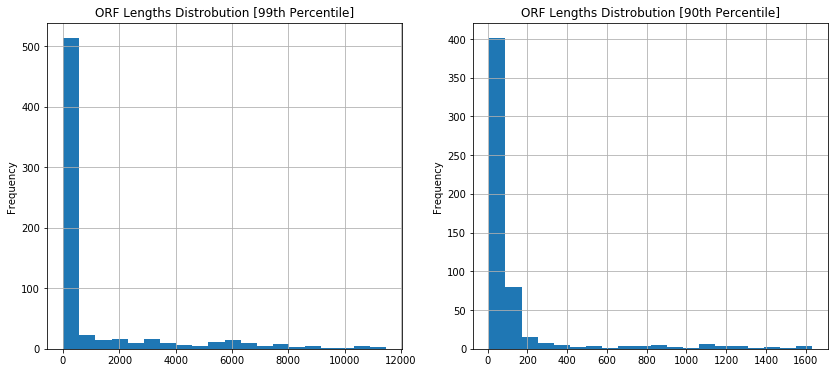

In [111]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=False, sharey=False)

df_orf_lengths[
    df_orf_lengths['Length'] < df_orf_lengths['Length'].quantile(0.99)
]['Length'].plot(
    title='ORF Lengths Distrobution [99th Percentile]',
    kind='hist',
    bins=20,
    grid=True,
    ax=axs[0]
)

df_orf_lengths[
    df_orf_lengths['Length'] < df_orf_lengths['Length'].quantile(0.80)
]['Length'].plot(
    title='ORF Lengths Distrobution [90th Percentile]',
    kind='hist',
    bins=20,
    grid=True,
    ax=axs[1]
)

fig.show()

## Picking potential genes
There is potential to generate on ORF by chance, thus we exclude lengths where ORF likelihood is above 5% or so.

In [143]:
proba_start = 1 / 64
proba_stop = 3 / 64

print(f'proba_start: {proba_start:.3f}, proba_stop: {proba_stop:.3f}')

proba_start: 0.016, proba_stop: 0.047


In [134]:
proba_no_stop = lambda k: (1 - proba_stop) ** k

In [147]:
df_proba_chance = pd.DataFrame(
    [
        (k, proba_no_stop(k))
        for k in range(9, 140, 3)
    ],
    columns=['Length', 'Proba Chance']
).set_index('Length')

/Users/tarek/anaconda3/envs/djs/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


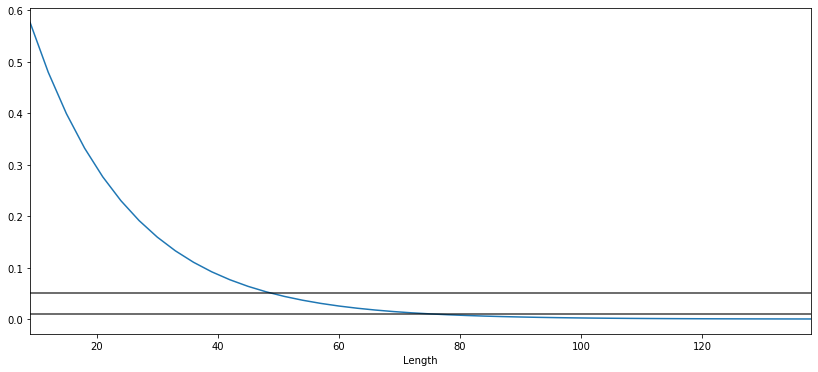

In [148]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6), sharex=False, sharey=False)

df_proba_chance['Proba Chance'].plot(
    kind='line',
    ax=ax
)

ax.axhline(0.05, color='k', alpha=0.75)
ax.axhline(0.01, color='k', alpha=0.75)

fig.show()

In [149]:
alphas = [0.05, 0.01]
    
for alpha in alphas:
    start_codon_len = stop_codon_len = 3
    min_length = df_proba_chance[
        df_proba_chance['Proba Chance'] < alpha
    ].index.min() + start_codon_len + stop_codon_len
    print(f'@ alpha = {alpha:.2f}, min length = {min_length:,}')

@ alpha = 0.05, min length = 57
@ alpha = 0.01, min length = 84


### Better Estimates for P(start_codon) & P(stop_codon) 

In [158]:
n_gram_length = 3
n_gram_freq = {}

for i in range(0, len(cov2genome) - n_gram_length + 1):
    n_gram = cov2genome[i:i+n_gram_length]
    n_gram_freq[n_gram] = n_gram_freq.get(n_gram, 0) + 1

In [159]:
df_n_gram_freq = pd.DataFrame(
    [n_gram_freq], index=['# Occurences']
).T

df_n_gram_freq = df_n_gram_freq / df_n_gram_freq.sum()

df_n_gram_freq.sort_values('# Occurences', ascending=False).head(8)

,# Occurences
TTT,0.033577
AAA,0.030869
TTA,0.029297
TGT,0.028695
TTG,0.027324
ACA,0.027056
ATT,0.025852
AAT,0.025451


In [160]:
proba_start = df_n_gram_freq[
    df_n_gram_freq.index == start_codon
].sum().values[0]

proba_stop = df_n_gram_freq[
    df_n_gram_freq.index.isin(stop_codons) 
].sum().values[0]

print(f'proba_start: {proba_start:.3f}, proba_stop: {proba_stop:.3f}')

proba_start: 0.024, proba_stop: 0.059


In [161]:
proba_no_stop = lambda k: (1 - proba_stop) ** k

In [162]:
df_proba_chance = pd.DataFrame(
    [
        (k, proba_no_stop(k))
        for k in range(9, 140, 3)
    ],
    columns=['Length', 'Proba Chance']
).set_index('Length')

/Users/tarek/anaconda3/envs/djs/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


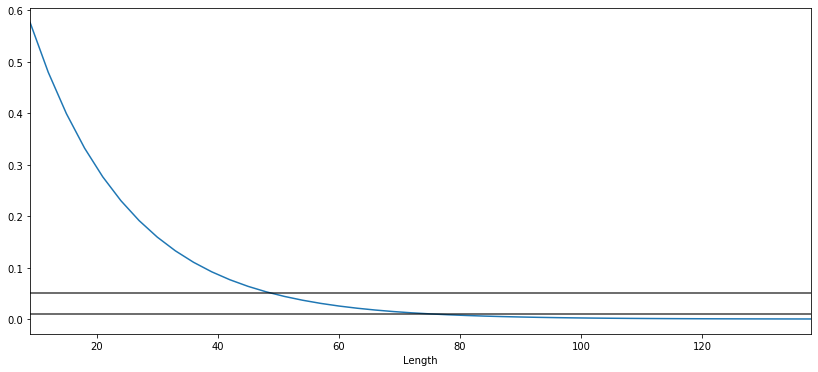

In [163]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6), sharex=False, sharey=False)

df_proba_chance['Proba Chance'].plot(
    kind='line',
    ax=ax
)

ax.axhline(0.05, color='k', alpha=0.75)
ax.axhline(0.01, color='k', alpha=0.75)

fig.show()

In [164]:
alphas = [0.05, 0.01]
    
for alpha in alphas:
    start_codon_len = stop_codon_len = 3
    min_length = df_proba_chance[
        df_proba_chance['Proba Chance'] < alpha
    ].index.min() + start_codon_len + stop_codon_len
    print(f'@ alpha = {alpha:.2f}, min length = {min_length:,}')

@ alpha = 0.05, min length = 57
@ alpha = 0.01, min length = 84


### Get Potential Genes
@ p=5%, we can accept all ORF of 57 nucleotide or longer

In [172]:
potential_genes = [
    orf for orf in orfs if len(orf) > 57
]

In [173]:
len(potential_genes)

368

In [178]:
print(
    '\n\n'.join(potential_genes)
)

ATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGATTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGGCCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTGTCCGAACAACTGGACTTTATTGACACTAAGAGGGGTGTATACTGCTGCCGTGAACATGAGCATGAAATTGCTTGGTACACGGAACGTTCTGAAAAGAGCTATGAATTGCAGACACCTTTTGAAATTAAATTGGCAAAGAAATTTGACACCTTCAATGGGGAATGTCCAAATTTTGTATTTCCCTTAAATTCCATAATCAAGACTATTCAACCAAGGGTTGAAAAGAAAAAGCTTGATGGCTTTATGGGTAGAATTCGATCTGTCTATCCAGTTGCGTCACCAAATGAATGCAACCAAATGTGCCTTTCAACTCTCATGAAGTGTGATCATTGTGGTGAAACTTCATGGCAGACGG